In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras import optimizers, metrics, backend as K

VAL_MAXLEN = 16


def truncated_acc(y_true, y_pred):
    y_true = y_true[:, :VAL_MAXLEN, :]
    y_pred = y_pred[:, :VAL_MAXLEN, :]
    
    acc = metrics.categorical_accuracy(y_true, y_pred)
    return K.mean(acc, axis=-1)


def truncated_loss(y_true, y_pred):
    y_true = y_true[:, :VAL_MAXLEN, :]
    y_pred = y_pred[:, :VAL_MAXLEN, :]
    
    loss = K.categorical_crossentropy(
        target=y_true, output=y_pred, from_logits=False)
    return K.mean(loss, axis=-1)


def seq2seq(hidden_size, nb_input_chars, nb_target_chars):
  
    encoder_inputs = Input(shape=(None, nb_input_chars),
                           name='encoder_data')
    encoder_lstm = LSTM(hidden_size, recurrent_dropout=0.2,
                        return_sequences=True, return_state=False,
                        name='encoder_lstm_1')
    encoder_outputs = encoder_lstm(encoder_inputs)
    
    encoder_lstm = LSTM(hidden_size, recurrent_dropout=0.2,
                        return_sequences=False, return_state=True,
                        name='encoder_lstm_2')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_outputs)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None, nb_target_chars),
                           name='decoder_data')
    
    decoder_lstm = LSTM(hidden_size, dropout=0.2, return_sequences=True,
                        return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_softmax = Dense(nb_target_chars, activation='softmax',
                            name='decoder_softmax')
    decoder_outputs = decoder_softmax(decoder_outputs)

    
    model = Model(inputs=[encoder_inputs, decoder_inputs],
                  outputs=decoder_outputs)
    
    adam = optimizers.Adam(lr=0.001, decay=0.0)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=['accuracy', truncated_acc, truncated_loss])
    
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_softmax(decoder_outputs)
    decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                          outputs=[decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

Using TensorFlow backend.


In [0]:
!pip install unidecode

In [0]:
import re
import os
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input

# from model import truncated_acc, truncated_loss

np.random.seed(1234)

SOS = '\t' # start of sequence.
EOS = '*' # end of sequence.
CHARS = list('abcdefghijklmnopqrstuvwxyzйцукенгшщзхъфывапролджэячсмитьбюё ')
REMOVE_CHARS = '[#$%"\+@<=>!&,-.?:;()*\[\]^_`{|}~/\d\t\n\r\x0b\x0c]'


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
          chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char2index = dict((c, i) for i, c in enumerate(self.chars))
        self.index2char = dict((i, c) for i, c in enumerate(self.chars))
        self.size = len(self.chars)
    
    def encode(self, C, nb_rows):
        """One-hot encode given string C.
        # Arguments
          C: string, to be encoded.
          nb_rows: Number of rows in the returned one-hot encoding. This is
          used to keep the # of rows for each data the same via padding.
        """
        x = np.zeros((nb_rows, len(self.chars)), dtype=np.float32)
        for i, c in enumerate(C):
            x[ i, self.char2index[c]] = 1.0
            i
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
          x: A vector or 2D array of probabilities or one-hot encodings,
          or a vector of character indices (used with `calc_argmax=False`).
          calc_argmax: Whether to find the character index with maximum
          probability, defaults to `True`.
        """
        if calc_argmax:
            indices = x.argmax(axis=-1)
        else:
            indices = x
        chars = ''.join(self.index2char[ind] for ind in indices)
        return indices, chars

    def sample_multinomial(self, preds, temperature=1.0):
        """Sample index and character output from `preds`,
        an array of softmax probabilities with shape (1, 1, nb_chars).
        """
        # Reshaped to 1D array of shape (nb_chars,).
        preds = np.reshape(preds, len(self.chars)).astype(np.float64)
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probs = np.random.multinomial(1, preds, 1)
        index = np.argmax(probs)
        char  = self.index2char[index]
        return index, char


def read_text(data_path, list_of_books):
    text = ''
    for book in list_of_books:
        file_path = os.path.join(data_path, book)
        strings = open(file_path).read()
        text += strings + ' '
    return text


def tokenize(text):
#     tokens = [re.sub(REMOVE_CHARS, '', token)
#               for token in re.split("[-\n ]", text)]
    tokens = re.findall(r'\w+', text.lower())
    token = ''.join(str(e) for e in tokens)
    return tokens
    

    
def add_speling_erors(token, error_rate):
    """Simulate some artificial spelling mistakes."""
    assert(0.0 <= error_rate < 1.0)
    if len(token) < 3:
        return token
    rand = np.random.rand()
    # Here are 4 different ways spelling mistakes can occur,
    # each of which has equal chance.
    prob = error_rate / 4.0
    if rand < prob:
        # Replace a character with a random character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + np.random.choice(CHARS) \
                + token[random_char_index + 1:]
    elif prob < rand < prob * 2:
        # Delete a character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + token[random_char_index + 1:]
    elif prob * 2 < rand < prob * 3:
        # Add a random character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + np.random.choice(CHARS) \
                + token[random_char_index:]
    elif prob * 3 < rand < prob * 4:
        # Transpose 2 characters.
        random_char_index = np.random.randint(len(token) - 1)
        token = token[:random_char_index]  + token[random_char_index + 1] \
                + token[random_char_index] + token[random_char_index + 2:]
    else:
        # No spelling errors.
        pass
    return token


def transform(tokens, maxlen, error_rate=0.3, shuffle=True):
    """Transform tokens into model inputs and targets.
    All inputs and targets are padded to maxlen with EOS character.
    """
    if shuffle:
        print('Shuffling data.')
        np.random.shuffle(tokens)
    encoder_tokens = []
    decoder_tokens = []
    target_tokens = []
    for token in tokens:
        encoder = add_speling_erors(token, error_rate=error_rate)
        encoder += EOS * (maxlen - len(encoder)) # Padded to maxlen.
        encoder_tokens.append(encoder)
    
        decoder = SOS + token
        decoder += EOS * (maxlen - len(decoder))
        decoder_tokens.append(decoder)
    
        target = decoder[1:]
        target += EOS * (maxlen - len(target))
        target_tokens.append(target)
        
        assert(len(encoder) == len(decoder) == len(target))
    return encoder_tokens, decoder_tokens, target_tokens


def batch(tokens, maxlen, ctable, batch_size=128, reverse=False):
    """Split data into chunks of `batch_size` examples."""
    def generate(tokens, reverse):
        while(True): # This flag yields an infinite generator.
            for token in tokens:
                if reverse:
                    token = token[::-1]
                yield token
    
    token_iterator = generate(tokens, reverse)
    data_batch = np.zeros((batch_size, maxlen, ctable.size),
                          dtype=np.float32)
    while(True):
        for i in range(batch_size):
            token = next(token_iterator)
            data_batch[i] = ctable.encode(token, maxlen)
        yield data_batch


def datagen(encoder_iter, decoder_iter, target_iter):
    """Utility function to load data into required model format."""
    inputs = zip(encoder_iter, decoder_iter)
    while(True):
        encoder_input, decoder_input = next(inputs)
        target = next(target_iter)
        yield ([encoder_input, decoder_input], target)


def decode_sequences(inputs, targets, input_ctable, target_ctable,
                     maxlen, reverse, encoder_model, decoder_model,
                     nb_examples, sample_mode='argmax', random=True):
    input_tokens = []
    target_tokens = []
    
    if random:
        indices = np.random.randint(0, len(inputs), nb_examples)
    else:
        indices = range(nb_examples)
        
    for index in indices:
        input_tokens.append(inputs[index])
        target_tokens.append(targets[index])
    input_sequences = batch(input_tokens, maxlen, input_ctable,
                            nb_examples, reverse)
    input_sequences = next(input_sequences)
    
    # Procedure for inference mode (sampling):
    # 1) Encode input and retrieve initial decoder state.
    # 2) Run one step of decoder with this initial state
    #    and a start-of-sequence character as target.
    #    Output will be the next target character.
    # 3) Repeat with the current target character and current states.

    # Encode the input as state vectors.    
    states_value = encoder_model.predict(input_sequences)
    
    # Create batch of empty target sequences of length 1 character.
    target_sequences = np.zeros((nb_examples, 1, target_ctable.size))
    # Populate the first element of target sequence
    # with the start-of-sequence character.
    target_sequences[:, 0, target_ctable.char2index[SOS]] = 1.0

    # Sampling loop for a batch of sequences.
    # Exit condition: either hit max character limit
    # or encounter end-of-sequence character.
    decoded_tokens = [''] * nb_examples
    for _ in range(maxlen):
        # `char_probs` has shape
        # (nb_examples, 1, nb_target_chars)
        char_probs, h, c = decoder_model.predict(
            [target_sequences] + states_value)

        # Reset the target sequences.
        target_sequences = np.zeros((nb_examples, 1, target_ctable.size))

        # Sample next character using argmax or multinomial mode.
        sampled_chars = []
        for i in range(nb_examples):
            if sample_mode == 'argmax':
                next_index, next_char = target_ctable.decode(
                    char_probs[i], calc_argmax=True)
            elif sample_mode == 'multinomial':
                next_index, next_char = target_ctable.sample_multinomial(
                    char_probs[i], temperature=0.5)
            else:
                raise Exception(
                    "`sample_mode` accepts `argmax` or `multinomial`.")
            decoded_tokens[i] += next_char
            sampled_chars.append(next_char) 
            # Update target sequence with index of next character.
            target_sequences[i, 0, next_index] = 1.0

        stop_char = set(sampled_chars)
        if len(stop_char) == 1 and stop_char.pop() == EOS:
            break
            
        # Update states.
        states_value = [h, c]
    
    # Sampling finished.
    input_tokens   = [re.sub('[%s]' % EOS, '', token)
                      for token in input_tokens]
    target_tokens  = [re.sub('[%s]' % EOS, '', token)
                      for token in target_tokens]
    decoded_tokens = [re.sub('[%s]' % EOS, '', token)
                      for token in decoded_tokens]
    return input_tokens, target_tokens, decoded_tokens


def restore_model(path_to_full_model, hidden_size):
    """Restore model to construct the encoder and decoder."""
    model = load_model(path_to_full_model, custom_objects={
        'truncated_acc': truncated_acc, 'truncated_loss': truncated_loss})
    
    encoder_inputs = model.input[0] # encoder_data
    encoder_lstm1 = model.get_layer('encoder_lstm_1')
    encoder_lstm2 = model.get_layer('encoder_lstm_2')
    
    encoder_outputs = encoder_lstm1(encoder_inputs)
    _, state_h, state_c = encoder_lstm2(encoder_outputs)
    encoder_states = [state_h, state_c]
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

    decoder_inputs = model.input[1] # decoder_data
    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.get_layer('decoder_lstm')
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_softmax = model.get_layer('decoder_softmax')
    decoder_outputs = decoder_softmax(decoder_outputs)
    decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                          outputs=[decoder_outputs] + decoder_states)
    return encoder_model, decoder_model

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/NEWDATA'
import numpy as np
train_books = ['tovar.txt' , 'txt1.txt' , 'txt2.txt' , 'txt3.txt' , 'txt4.txt' ,'txt5.txt']
text  = read_text(data_path, train_books)
vocab = tokenize(text)
vocab = list(filter(None, set(vocab)))
import numpy as np
    # `maxlen` is the length of the longest word in the vocabulary
    # plus two SOS and EOS characters.
maxlen = max([len(token) for token in vocab]) + 2
val_tokens = list(filter(None, val_tokens))
print(vocab)
print(val_tokens)
print(np.shape(val_tokens))
val_batch_size = 256
val_steps = len(val_tokens) // val_batch_size
print(val_steps)

NameError: ignored

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/NEWDATA'
import numpy as np
train_books = ['tovar.txt']
text  = read_text(data_path, train_books)
vocab = tokenize(text)
vocab = list(filter(None, set(vocab)))
import numpy as np
    # `maxlen` is the length of the longest word in the vocabulary
    # plus two SOS and EOS characters.
maxlen = max([len(token) for token in vocab]) + 2
val_tokens = tokenize(text)
val_tokens = list(filter(None, val_tokens))
print(vocab)
print(val_tokens)
print(np.shape(val_tokens))
val_batch_size = 256
val_steps = len(val_tokens) // val_batch_size
print(val_steps)

['средний', '720b', 'кардана', 'just', 'optimist', 'мулан', 'cartella', 'новейший', 'сотникова', 'apbx', 'ddx7018btm', 'жесткий', 'heather', '1gd', '6091ogb', 'строитель', 'поток', 'xg27vq', '10744', 'ecocool', 'чудес', 'r15', '724d', 'tuf', '2620', '120', '3752', 'основателем', '3700', 'тасты', 'oreon', 'никогда', 'm6', '66813c', 'часы', '064g', 'белый', 'биол', 'оливии', 's05', 'll_powder', 'mammoet', 'stay', '5203x', '62', 'зарык', 'lorelli', 'bat', 'посуда', 'cf211a', 'дом', 'машинка', 'penny', 'lips', 'унитазы', 'лей', 'brooklyn', 'av175', 'горнолыжные', 'подъёмный', 'mattel', 'bombini', '708', 'gold', 'мастер', 'tr', '5gy79ea', '193274', 'оранжерея', 'fatal1ty', 'пупс', 'wj785', 'к007043', '870', '1581', 'gzht', 'rupl', 'bmg2', 'darloni', 'узбекский', 'динар', 'штукатурки', 'вязания', 'оборудование', 'microsoft', 'mjm204c3e', 'tcrd', 'rw11', 'косточки', 'школе', 'soc', 'smc015_01_03_nk', '14445', '184195', '211', 'taxi', 'обеденные', 'грузинский', 'mex', 'surfs', 'ag002', 'bayer'

In [0]:
def transform_pred(tokens ,maxlen , error_rate = 0.3 , shuffle = True):
    if shuffle:
        print("Shuffling data.")
        no.random.shuffle(tokens)
    input_tokens = []
    decoder_tokens = []
    for token in tokens:
        decoder = SOS + token
        decoder += EOS * (maxlen - len(decoder))
        decoder_tokens.append(decoder)
    
        inp = decoder[1:]
        inp += EOS * (maxlen - len(inp))
        input_tokens.append(inp)
        
        assert(len(decoder) == len(inp))
    return input_tokens  

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/NEWDATA'
import numpy as np
train_books = ['tovar.txt']
text  = read_text(data_path, train_books)
vocab = tokenize(text)
print(np.shape(vocab))
vocab

In [0]:
def decode_sequences_pred(inputs, input_ctable, target_ctable,
                     maxlen, reverse, encoder_model, decoder_model,
                     nb_examples, sample_mode='argmax', random=True):
    input_tokens = []
    target_tokens = []
    
    if random:
        indices = np.random.randint(0, len(inputs), nb_examples)
    else:
        indices = range(nb_examples)
        
    for index in indices:
        input_tokens.append(inputs[index])
        
    input_sequences = batch(input_tokens, maxlen, input_ctable, nb_examples, reverse)
    input_sequences = next(input_sequences)
    
    # Procedure for inference mode (sampling):
    # 1) Encode input and retrieve initial decoder state.
    # 2) Run one step of decoder with this initial state
    #    and a start-of-sequence character as target.
    #    Output will be the next target character.
    # 3) Repeat with the current target character and current states.

    # Encode the input as state vectors.    
    states_value = encoder_model.predict(input_sequences)
    
    # Create batch of empty target sequences of length 1 character.
    target_sequences = np.zeros((nb_examples, 1, target_ctable.size))
    # Populate the first element of target sequence
    # with the start-of-sequence character.
    target_sequences[:, 0, target_ctable.char2index[SOS]] = 1.0

    # Sampling loop for a batch of sequences.
    # Exit condition: either hit max character limit
    # or encounter end-of-sequence character.
    decoded_tokens = [''] * nb_examples
    for _ in range(maxlen):
        # `char_probs` has shape
        # (nb_examples, 1, nb_target_chars)
        char_probs, h, c = decoder_model.predict([target_sequences] + states_value)

        # Reset the target sequences.
        target_sequences = np.zeros((nb_examples, 1, target_ctable.size))

        # Sample next character using argmax or multinomial mode.
        sampled_chars = []
        for i in range(nb_examples):
            if sample_mode == 'argmax':
                next_index, next_char = target_ctable.decode(char_probs[i], calc_argmax=True)
            elif sample_mode == 'multinomial':
                next_index, next_char = target_ctable.sample_multinomial(char_probs[i], temperature=0.5)
            else:
                raise Exception(
                    "`sample_mode` accepts `argmax` or `multinomial`.")
            decoded_tokens[i] += next_char
            sampled_chars.append(next_char) 
            # Update target sequence with index of next character.
            target_sequences[i, 0, next_index] = 1.0

        stop_char = set(sampled_chars)
        if len(stop_char) == 1 and stop_char.pop() == EOS:
            break
            
        # Update states.
        states_value = [h, c]
    
    # Sampling finished.
    input_tokens   = [re.sub('[%s]' % EOS, '', token)
                      for token in input_tokens]
    decoded_tokens = [re.sub('[%s]' % EOS, '', token)
                      for token in decoded_tokens]
    return input_tokens, decoded_tokens

In [0]:
import os
import numpy as np
np.random.seed(1234)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
accp = []
lossp = []
truncated_accp = [] 
truncated_lossp = []
val_lossp = []
val_accp = []
val_truncated_accp = []
val_truncated_lossp = []

error_rate = 0.8
hidden_size = 512
nb_epochs = 100
train_batch_size = 128
val_batch_size = 256
sample_mode = 'argmax'

# Input sequences may optionally be reversed,
# shown to increase performance by introducing
# shorter term dependencies between source and target:
# "Learning to Execute"
# http://arxiv.org/abs/1410.4615
# "Sequence to Sequence Learning with Neural Networks"
# https://arxiv.org/abs/1409.3215
reverse = True

data_path = '/content/drive/My Drive/Colab Notebooks/data'
train_books = ['tovar.txt' , 'txt1.txt' , 'txt2.txt' , 'txt3.txt' , 'txt4.txt' ,'txt5.txt']
val_books = ['tovar.txt']


if __name__ == '__main__':
    # Prepare training data.
    text  = read_text(data_path, train_books)
    vocab = tokenize(text)
    vocab = list(filter(None, set(vocab)))
    
    # `maxlen` is the length of the longest word in the vocabulary
    # plus two SOS and EOS characters.
    maxlen = max([len(token) for token in vocab]) + 2
    train_encoder, train_decoder, train_target = transform(vocab, maxlen, error_rate=error_rate, shuffle=False)
    print(train_encoder[:10])
    print(train_decoder[:10])
    print(train_target[:10])

    input_chars = set(' '.join(train_encoder))
    target_chars = set(' '.join(train_decoder))
    nb_input_chars = len(input_chars)
    nb_target_chars = len(target_chars)

    print('Size of training vocabulary =', len(vocab))
    print('Number of unique input characters:', nb_input_chars)
    print('Number of unique target characters:', nb_target_chars)
    print('Max sequence length in the training set:', maxlen)

    # Prepare validation data.
    text = read_text(data_path, val_books)
    text = text.lower()
    val_tokens = tokenize(text)
    val_tokens = list(filter(None, val_tokens))

    val_maxlen = max([len(token) for token in val_tokens]) + 2
    val_encoder, val_decoder, val_target = transform(
        val_tokens, maxlen, error_rate=error_rate, shuffle=False)
    print(val_encoder[:10])
    print(val_decoder[:10])
    print(val_target[:10])
    print('Number of non-unique validation tokens =', len(val_tokens))
    print('Max sequence length in the validation set:', val_maxlen)

    # Define training and evaluation configuration.
    input_ctable  = CharacterTable(input_chars)
    target_ctable = CharacterTable(target_chars)

    train_steps = len(vocab) // train_batch_size
    val_steps = len(val_tokens) // val_batch_size

    # Compile the model.
    model, encoder_model, decoder_model = seq2seq(hidden_size, nb_input_chars, nb_target_chars)
    print(model.summary())

    # Train and evaluate.
    import matplotlib.pyplot as plt
    for epoch in range(nb_epochs):
        print('Main Epoch {:d}/{:d}'.format(epoch + 1, nb_epochs))
    
        train_encoder, train_decoder, train_target = transform(
            vocab, maxlen, error_rate=error_rate, shuffle=True)
        
        train_encoder_batch = batch(train_encoder, maxlen, input_ctable,
                                    train_batch_size, reverse)
        train_decoder_batch = batch(train_decoder, maxlen, target_ctable,
                                    train_batch_size)
        train_target_batch  = batch(train_target, maxlen, target_ctable,
                                    train_batch_size)    

        val_encoder_batch = batch(val_encoder, maxlen, input_ctable,
                                  val_batch_size, reverse)
        val_decoder_batch = batch(val_decoder, maxlen, target_ctable,
                                  val_batch_size)
        val_target_batch  = batch(val_target, maxlen, target_ctable,
                                  val_batch_size)
    
        train_loader = datagen(train_encoder_batch,
                               train_decoder_batch, train_target_batch)
        val_loader = datagen(val_encoder_batch,
                             val_decoder_batch, val_target_batch)
    
        asd = model.fit_generator(train_loader,steps_per_epoch=train_steps,
                                  epochs=1, verbose=1,
                                  validation_data=val_loader,
                                  validation_steps=val_steps) 
        accp.append(asd.history['acc'])
        lossp.append(asd.history['loss'])
        truncated_accp.append(asd.history['truncated_acc'])
        truncated_lossp.append(asd.history['truncated_loss'])
        val_accp.append(asd.history['val_acc'])
        val_lossp.append(asd.history['val_loss'])
        val_truncated_accp.append(asd.history['val_truncated_acc'])
        val_truncated_lossp.append(asd.history['val_truncated_loss'])
        # On epoch end - decode a batch of misspelled tokens from the
        # validation set to visualize speller performance.
        nb_tokens = 5
        input_tokens, target_tokens, decoded_tokens = decode_sequences(
            val_encoder, val_target, input_ctable, target_ctable,
            maxlen, reverse, encoder_model, decoder_model, nb_tokens,
            sample_mode=sample_mode, random=True)
        
        print('-')
        print('Input tokens:  ', input_tokens)
        print('Decoded tokens:', decoded_tokens)
        print('Target tokens: ', target_tokens)
        print('-')
        
        # Save the model at end of each epoch.
        model_file = '_'.join(['seq2seq', 'epoch', str(epoch + 1)]) + '.h5'
        save_dir = 'checkpoints'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, model_file)
        print('Saving full model to {:s}'.format(save_path))
        model.save(save_path)
#         plt.plot(asd.history['loss']
#         plt.plot(asd.history['val_loss'])
#         plt.title('Model loss')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')
#         plt.show()

['25neм******************', 'usnensuousness*********', '013192*****************', 'goоt*******************', 'hpё********************', 'f25********************', 'purpos*****************', 'heэen******************', 'despoщndency***********', 'dipomacy***************']
['\t25neo*****************', '\tunsensuousness********', '\t0183192***************', '\tgoot******************', '\thpe*******************', '\t725*******************', '\tpurpose***************', '\thelen*****************', '\tdespondency***********', '\tdiplomacy*************']
['25neo******************', 'unsensuousness*********', '0183192****************', 'goot*******************', 'hpe********************', '725********************', 'purpose****************', 'helen******************', 'despondency************', 'diplomacy**************']
Size of training vocabulary = 37588
Number of unique input characters: 79
Number of unique target characters: 80
Max sequence length in the training set: 23
['касегории*********

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Main Epoch 2/100
Shuffling data.
Epoch 1/1
293/293 [==============================] - 38s 129ms/step - loss: 1.0838 - acc: 0.7160 - truncated_acc: 0.5918 - truncated_loss: 1.5571 - val_loss: 0.9472 - val_acc: 0.7604 - val_truncated_acc: 0.6556 - val_truncated_loss: 1.3611
-
Input tokens:   ['автоакуyстика', 'укьашения', 'камекы', 'g3050k', 'swarovski']
Decoded tokens: ['serere', 'seres', 'seres', 'seres', 'seres']
Target tokens:  ['автоакустика', 'украшения', 'камеры', 'g3500k', 'swarovski']
-
Saving full model to checkpoints/seq2seq_epoch_2.h5
Main Epoch 3/100
Shuffling data.
Epoch 1/1
293/293 [==============================] - 38s 129ms/step - loss: 1.0651 - acc: 0.7207 - truncated_acc: 0.5985 - truncated_loss: 1.5304 - val_loss: 0.9025 - val_acc: 0.7682 - val_truncated_acc: 0.6668 - val_truncated_loss: 1.2969
-
Input tokens:   ['наволочи', 'автозапчасти', 'космmтика', 'детске', 'комсетика']
Decoded tokens: ['корони', 'короно', 'корони', 'коро', 'корони']
Target tokens:  ['наволочки'

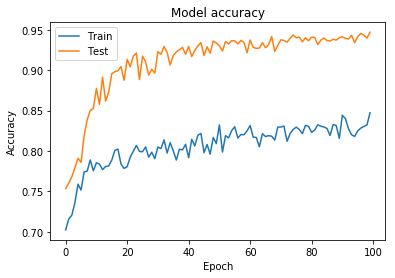

In [0]:
import matplotlib.pyplot as plt
plt.plot(accp)
plt.plot(val_accp)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('KASPI_Acc.png')
plt.show()

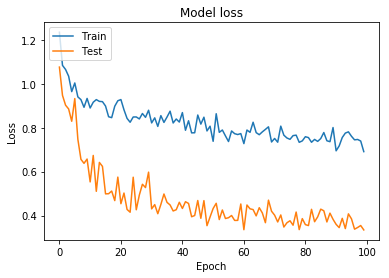

In [0]:
plt.plot(lossp)
plt.plot(val_lossp)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('KASPI_Loss.png')
plt.show()

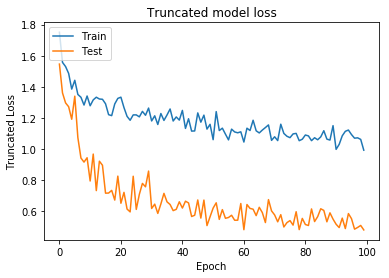

In [0]:
plt.plot(truncated_lossp)
plt.plot(val_truncated_lossp)
plt.title('Truncated model loss')
plt.ylabel('Truncated Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Truncated_KASPI_Loss.png')
plt.show()

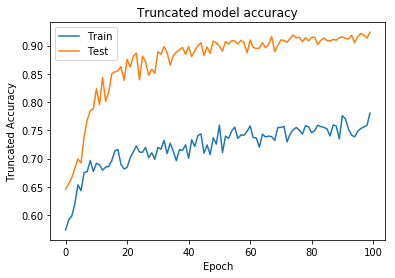

In [0]:
plt.plot(truncated_accp)
plt.plot(val_truncated_accp)
plt.title('Truncated model accuracy')
plt.ylabel('Truncated Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Truncated_KASPI_Acc.png')
plt.show()

In [0]:
model.save('KASPIWITHCLASSIC.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# from utils import CharacterTable, transform
# from utils import restore_model, decode_sequences
# from utils import read_text, tokenize
# This repository cnotains a Keras mplementation of an encoder-decoder LSTM architecture for sequence-to-sequence speling correction
error_rate = 0.6
reverse = True
model_path = 'KASPIWITHCLASSIC.h5'
hidden_size = 512
sample_mode = 'argmax'
data_path = '/content/drive/My Drive/Colab Notebooks/data'
books = ['tovar.txt' , 'txt1.txt' , 'txt2.txt', 'txt3.txt' , 'txt4.txt' , 'txt5.txt']
start_time = time.clock()
test_sentence = input("Enter any text: ")


if __name__ == '__main__':
    text  = read_text(data_path, books)
    vocab = tokenize(text)
    vocab = list(filter(None, set(vocab)))
    # `maxlen` is the length of the longest word in the vocabulary
    # plus two SOS and EOS characters.
    maxlen = max([len(token) for token in vocab]) + 2
    train_encoder, train_decoder, train_target = transform(vocab, maxlen, error_rate=error_rate, shuffle=False)

    tokens = tokenize(test_sentence)
    tokens = list(filter(None, tokens))
    nb_tokens = len(tokens)
    _, _, target_tokens = transform(tokens, maxlen, error_rate=error_rate, shuffle=False)

    
    input_chars = set(' '.join(train_encoder))
    target_chars = set(' '.join(train_decoder))
    input_ctable = CharacterTable(input_chars)

    target_ctable = CharacterTable(target_chars) 
    encoder_model, decoder_model = restore_model(model_path, hidden_size)
    
    input_tokens, _, decoded_tokens = decode_sequences(
        target_tokens, target_tokens, input_ctable, target_ctable,
        maxlen, reverse, encoder_model, decoder_model, nb_tokens,
        sample_mode=sample_mode, random=False)
    
    
    print('Maybe you meant:', ' '.join([token for token in decoded_tokens]))
    print(time.clock() - start_time, "seconds")

Enter any text: buyy samsung glaaxy
Maybe you meant: buy samsung glaxy
23.53549000000021 seconds


In [0]:
model.save('kaspiprediction.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
